# Distinguish quanities can be used to tell goodness of the reconstruction

This notebook is about distinguish quantitis from $N_{hit}$, $pt$, $\eta$, $\Delta\eta$, $\Delta\phi$, $\theta$, $qop$, using Permutation feature importance method

In [180]:
# Load lib
from sklearn.inspection import permutation_importance
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [181]:
# Load test set
folder  = "75_dataset_phi"

test_input = torch.load(f"data/{folder}/data_test_input.csv",weights_only=False)
test_label = torch.load(f"data/{folder}/data_test_label.csv",weights_only=False)

index = 3000 # This index is define to distinguish good recons and bad recons in the test set, i.e.[0,index] are good recons and the rest are bad recons

In [182]:
# Load model
class net(nn.Module):

    def __init__(self):
        super().__init__()

        self.classi = nn.Sequential(
            nn.Linear(8,512),
            nn.Linear(512,512),
            nn.Linear(512,512),
            nn.Linear(512,512),
            nn.Linear(512,256),
            nn.Linear(256,128),
            nn.Linear(128,64),
            nn.Linear(64,32),
            nn.Linear(32,2),nn.Sigmoid()
        )
    def forward(self,inputs):
        output = self.classi(inputs)

        return output

PATH = './cifar_net.pth'
model = net()
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()
model.to('cuda')

net(
  (classi): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): Linear(in_features=32, out_features=2, bias=True)
    (9): Sigmoid()
  )
)

In order in avoid bias caused by inbalence between good recons and bad recons in the test set, select same number of good recons in test set and conbine this with bad recons, for simplicity, just choose first n number of the good recons

In [183]:
len_bad = 500
print(f"The test set has the size of {test_label.shape[0]}, with {index} good recons and {len_bad} recons")

new_test_input = torch.tensor([])
for i in range(len_bad):
    new_test_input = torch.cat((new_test_input,torch.tensor(test_input[i][:][None])),dim=0)
print(new_test_input.shape)
for i in range(index,test_label.shape[0]):
    new_test_input = torch.cat((new_test_input,torch.tensor(test_input[i][:][None])),dim=0)
print(new_test_input.shape)

new_test_label = torch.cat((torch.tensor([1,0]).repeat(len_bad,1),torch.tensor([0,1]).repeat(len_bad,1)),dim = 0)


print(f"Type: {type(new_test_input)} Length: {new_test_input.shape}")
print(f"Type: {type(new_test_label)} Length: {new_test_label.shape}")

The test set has the size of 3500, with 3000 good recons and 500 recons
torch.Size([500, 8])
torch.Size([1000, 8])
Type: <class 'torch.Tensor'> Length: torch.Size([1000, 8])
Type: <class 'torch.Tensor'> Length: torch.Size([1000, 2])


C:\Users\JEFF-wei\AppData\Local\Temp\ipykernel_10592\1362833706.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_test_input = torch.cat((new_test_input,torch.tensor(test_input[i][:][None])),dim=0)
C:\Users\JEFF-wei\AppData\Local\Temp\ipykernel_10592\1362833706.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_test_input = torch.cat((new_test_input,torch.tensor(test_input[i][:][None])),dim=0)


In [184]:
# Calculate score 

accuracy_good = 0
accuracy_bad = 0

for i in range(len_bad):
    inputs = new_test_input[i].to("cuda")
    output = model(inputs)
    if output[0]>output[1]:
        accuracy_good += 1
for i in range(len_bad,new_test_input.shape[0]):
    inputs = new_test_input[i].to("cuda")
    output = model(inputs)
    if output[0]<output[1]:
        accuracy_bad += 1

accuracy_good = accuracy_good / (len_bad)
accuracy_bad = accuracy_bad / (len_bad)
print(f"Accuracy of good recons is {accuracy_good}")
print(f"Accuracy of poor recons is {accuracy_bad}")

from training_function import test_score
good_ref,bad_ref = test_score(model,new_test_input,index=500)



Accuracy of good recons is 0.714
Accuracy of poor recons is 0.774
The accuracy of the network for well reconstructed tracks is: 71.400%
The accuracy of the network for poor reconstructed tracks is: 77.400%
The accuracy of the network is: 74.400%


In [185]:
def pfi(model,input_data,index,q_index):
    """
    This function about using Permutation feature importance method to tell importance of a quanity with index q_index 

    Input:
        model: classification model
        input: input segood_reft
        index: [0,index] are good recons and [index,input.shape[0]] are bad recons
        q_index: index of quanties shuffed in input set

    Output: 
        Good: Accuracy of good recon
        Bad: Accuracy of bad recon
    """
    from training_function import test_score
    test_data = input_data.clone()
    #print(input.shape[0])
    temp = test_data[:,q_index]
    #print(f"Initially temp: {temp[0:5]}")
    #print(f"Initially: {test_data[0:5,q_index]}")
    test_data[:,q_index] = torch.rand(input_data.shape[0])
    #print(f"Now: {test_data[0:5,q_index]}")
    acc_g,acc_b = test_score(model,test_data,index=index,print_result = False)
    test_data[:,q_index] = temp
    #print(f"After: {test_data[0:5,q_index]}")
    return acc_g,acc_b
        

In [186]:
def test_a_quality(q_index,num_repeat = 50):
    """
    This function is used to tell importance of a quanity of a model using feature importance method with pfi function

    Input:
        q_index: index of quanties shuffed in input set
        num_repeat: repeating time of calculating difference, defult: 50
    
    Output:
        diff_g : difference of accuracy of good recons comparing with referencing value
        diff_b : difference of accuracy of bad recons comparing with referencing value
    """
    diff_g = np.array([])
    diff_b = np.array([])
    for i in range(num_repeat):
        acc_good,acc_bad = pfi(model,new_test_input,500,q_index)
        diff_g = np.append(diff_g,good_ref - acc_good)
        diff_b = np.append(diff_b,bad_ref - acc_bad)
    
    #print(diff_g)
    #print(diff_b)
    return diff_g,diff_b


Testing n_hit
Testing pt
Testing eta
Testing deta
Testing phi
Testing dphi
Testing theta
Testing qop


Text(0.5, 0, 'Decrease in Accuracy %')

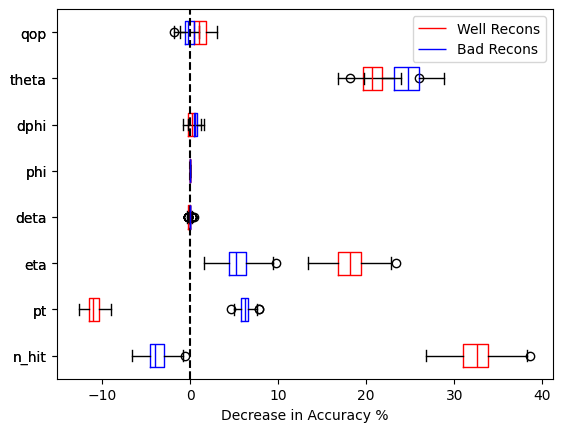

In [187]:
quantity = ["n_hit","pt","eta","deta","phi","dphi","theta","qop"]
diff_g_all= []
diff_b_all= []

for index in range (8):
    print(f"Testing {quantity[index]}")
    dif_g,dif_b = test_a_quality(index,100)
    diff_g_all.append(dif_g)
    diff_b_all.append(dif_b)


#print(diff_g_all)
#print(diff_b_all)
bx_1 = plt.boxplot(diff_g_all,tick_labels=quantity,vert = False,label = "Well Recons")
bx_2 = plt.boxplot(diff_b_all,tick_labels=quantity,vert = False,label = "Bad Recons")

for patch in bx_1['boxes']:
    patch.set_color('red')
for patch in bx_2['boxes']:
    patch.set_color('blue')
for patch in bx_1['medians']:
    patch.set_color('red')
for patch in bx_2['medians']:
    patch.set_color('blue')

lower, upper = plt.ylim()
plt.vlines(0, ymin=lower, ymax=upper, color='black', linestyles='--')   

plt.legend()
plt.xlabel("Decrease in Accuracy %")